In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as mcolors


cw = np.arange(5,80,5)
vals = {}
for c in cw:
    vals[c] = np.load(f'data/era_uw_ptv_level70hpa_10degintrinsic_cw_{c}.npy')

In [17]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = 'data/loon'
u_flux_ptv = []
u_flux_ntv = []
v_flux_ntv = []
v_flux_ptv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv.append(flux[2])    
    v_flux_ptv.append(flux[3])


loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_ntv_v = np.concatenate(v_flux_ntv)
loon_ptv_v = np.concatenate(v_flux_ptv)
loon_abs_v = np.concatenate([np.abs(loon_ntv_v)+np.abs(loon_ptv_v)])
loon_abs_u = np.concatenate([np.abs(loon_ntv_u)+np.abs(loon_ptv_u)])
loon_net_u = np.concatenate([loon_ntv_u+loon_ptv_u])
loon_net_v = np.concatenate([loon_ntv_v+loon_ptv_v])

LOON_DATA = {
    'u_flux_ntv': loon_ntv_u[loon_ntv_u<0],
    'u_flux_ptv': loon_ptv_u[loon_ptv_u>0],
    'v_flux_ntv': loon_ntv_v[loon_ntv_v<0],
    'v_flux_ptv': loon_ptv_v[loon_ptv_v>0],
    'u_flux_abs': loon_abs_u[loon_abs_u>0],
    'v_flux_abs': loon_abs_v[loon_abs_v>0],
    'u_flux_net': loon_net_u,
    'v_flux_net': loon_net_v
}

/tmp/ipykernel_127162/653359459.py:10: RuntimeWarning: invalid value encountered in log10
  loonhist, _ = np.histogram(np.log10(LOON_DATA['u_flux_net']),density=True,bins=bins)


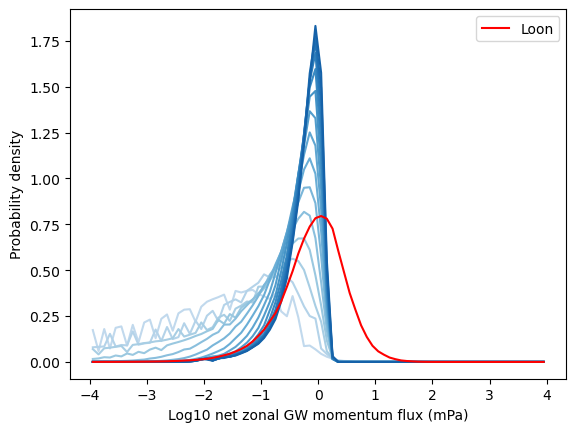

In [20]:
dc = 0.1
bins = np.arange(-4,4+dc,dc)
bin_centers = (bins[1:] + bins[:-1])*0.5
cmap = plt.get_cmap('Blues')  # or 'Blues', 'Purples', etc.
norm = mcolors.Normalize(vmin=-30, vmax=100)
for k,v in vals.items():
    hist, _ = np.histogram(np.log10(1000*v),bins=bins,density=True)
    color = cmap(norm(k))
    plt.plot(bin_centers,hist,color=color)
loonhist, _ = np.histogram(np.log10(LOON_DATA['u_flux_net']),density=True,bins=bins)
plt.plot(bin_centers,loonhist,color='red',label='Loon')
plt.xlabel("Log10 net zonal GW momentum flux (mPa)")
plt.ylabel("Probability density")
plt.legend()

In [22]:
def variance_and_skew(x):
    mean = np.nanmean(x,axis=-1,keepdims=True)
    var = np.nanmean((x - mean)**2,axis=-1,keepdims=True)
    skew = np.nanmean(((x - mean)/np.sqrt(var))**3,axis=-1)
    return np.squeeze(var,axis=-1),skew

vandskew= {k:variance_and_skew(v*1000) for k,v in vals.items()}
lonvandskew = vandskew= {k:variance_and_skew(np.log10(v*1000)) for k,v in vals.items()}


In [24]:
lonvandskew

{np.int64(5): (array(48.08878, dtype=float32), np.float32(-1.4891976)),
 np.int64(10): (array(15.191555, dtype=float32), np.float32(-0.9890799)),
 np.int64(15): (array(8.64172, dtype=float32), np.float32(-1.4598186)),
 np.int64(20): (array(7.5361433, dtype=float32), np.float32(-1.6527023)),
 np.int64(25): (array(5.3848157, dtype=float32), np.float32(-2.291413)),
 np.int64(30): (array(4.6872864, dtype=float32), np.float32(-2.582671)),
 np.int64(35): (array(4.7231584, dtype=float32), np.float32(-2.6303668)),
 np.int64(40): (array(4.179932, dtype=float32), np.float32(-2.8270607)),
 np.int64(45): (array(4.382719, dtype=float32), np.float32(-2.73574)),
 np.int64(50): (array(3.9528246, dtype=float32), np.float32(-2.97539)),
 np.int64(55): (array(3.7226744, dtype=float32), np.float32(-3.082861)),
 np.int64(60): (array(3.530951, dtype=float32), np.float32(-3.1884172)),
 np.int64(65): (array(3.231016, dtype=float32), np.float32(-3.3929114)),
 np.int64(70): (array(3.3406541, dtype=float32), np.f

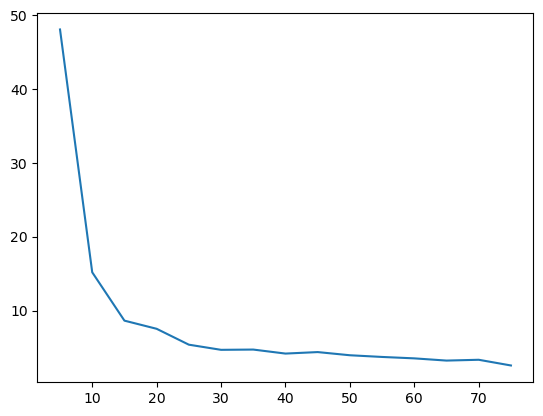

In [27]:
plt.plot(cw,[l[0] for l in lonvandskew.values()])

In [2]:
_,loonskew = variance_and_skew(np.log10(LOON_DATA['u_flux_net']))
plt.axhline(loonskew,ls='--',color='red',label='Loon')
plt.plot(cw,[l[1] for l in lonvandskew.values()])
plt.xlabel("$c_w$ (m/s)")
plt.ylabel("Skew of log10(Flux) PDF")
plt.legend()


NameError: name 'variance_and_skew' is not defined

## Correct mode

In [1]:
def adjust_log_mode(samples): 
    log_samples = np.log10(samples)
    log_samples = log_samples[~np.isnan(log_samples)]
    weights,edges = np.histogram(log_samples,bins=100)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    max_bin = np.argmax(weights)
    mode_bin = bin_centers[max_bin]
    intermittency_factor = 10**(-mode_bin)
    return samples*10**(-mode_bin),intermittency_factor
                